# When Explanations Lie: Why Modified BP Attribution fails

This notebook produces the cosine similaries of the relevance vectors.

In [1]:
# uncomment to install install packages
# !pip install tensorflow-gpu=1.13.1
# !pip install innvestigate seaborn tqdm

In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow
import tensorflow as tf
import warnings

import innvestigate
import matplotlib.pyplot as plt

import numpy as np
import PIL 
import copy
import contextlib

import imp
import numpy as np
import os

from skimage.measure import compare_ssim 
import pickle
from collections import OrderedDict
from IPython.display import IFrame, display

import keras
import keras.backend
import keras.models


import innvestigate
import innvestigate.applications.imagenet
import innvestigate.utils as iutils
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis
from innvestigate.analyzer.relevance_based.relevance_analyzer import LRP
from innvestigate.analyzer.base import AnalyzerNetworkBase, ReverseAnalyzerBase
from innvestigate.analyzer.deeptaylor import DeepTaylor

import time
import tqdm

import seaborn as sns

import itertools
import matplotlib as mpl
from utils import *
from tensorflow.python.client import device_lib

/home/leonsixt/.conda/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/leonsixt/.conda/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/leonsixt/.conda/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/leonsixt/.conda/envs/py36/lib/python3.6/site-pack

In [4]:
def _prepare_model(self, model):
    return super(DeepTaylor, self)._prepare_model(model)

# otherwise DTD does not work on negative outputs
DeepTaylor._prepare_model = _prepare_model

In [5]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15531330488768485805, name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5289468455541471608
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6840755676416326088
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10960607642
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13509113766508786888
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:5e:00.0, compute capability: 6.1"]

In [6]:
# ! ls "/home/leonsixt/tmp/"

In [7]:
# path to imagenet validation
#imagenet_val_dir = "/mnt/ssd/data/imagenet/imagenet-raw/validation"
imagenet_val_dir = "/home/leonsixt/tmp/imagenet/imagenet-raw/validation/"
# path to examplary image
ex_image_path = "n01534433/ILSVRC2012_val_00015410.JPEG"
# number of images to run the evaluation
n_selected_imgs = 200

model_names = ['resnet50', 'vgg16']

In [8]:
model, innv_net, color_conversion = load_model('vgg16')
ex_image_vgg, ex_target, val_images, selected_img_idxs = load_val_images(
    innv_net, imagenet_val_dir, ex_image_path, n_selected_imgs)

keras.backend.clear_session()
model, innv_net, color_conversion = load_model('resnet50')
ex_image, ex_target, val_images, selected_img_idxs = load_val_images(
    innv_net, imagenet_val_dir, ex_image_path, n_selected_imgs)


assert ((ex_image - ex_image_vgg) == 0).all()

nice_layer_names = get_nice_layer_names(model)

Instructions for updating:
Colocations handled automatically by placer.


/home/leonsixt/.conda/envs/py36/lib/python3.6/site-packages/innvestigate/applications/imagenet.py:134: UserWarning: There are no patterns for network 'resnet50'.
  warnings.warn("There are no patterns for network '%s'." % netname)


In [9]:
n_layers = {'vgg16': 22, 'resnet50': 177}

replacement_layers = {
    'vgg16':  ['fc3', 'fc1', 'conv4_3', 'conv3_3', 'conv2_2'],
    'resnet50': ['dense', 'block5_1', 'block4_2', 'block3_4', 'block3_2', 'block2_2'],
}


output_shapes = get_output_shapes(model)

In [10]:
def hmap_postprocess_wrapper(name):
    return lambda x: heatmap_postprocess(name, x)

input_range = (ex_image.min(), ex_image.max())
analysers = get_analyser_params(input_range)

attr_names = [n for (n, _, _, _, _) in analysers]
    
hmap_postprocessing = {
    n: hmap_postprocess_wrapper(post_name) for n, _, post_name, _, _ in analysers
}

In [11]:
n_layers = {'vgg16': 22, 'resnet50': 177}

In [12]:
model_names

['resnet50', 'vgg16']

In [13]:
bins = np.linspace(0, 0.9, 10).tolist() + [0.99, 0.999, 0.9999, 1]

In [14]:
n_layers

{'vgg16': 22, 'resnet50': 177}

In [15]:
def parse_reversed(hidden):
    return [h[1] for h in hidden[1:]]


dead_neuron_mask = {}

for model_name in model_names:
    keras.backend.clear_session()
    model, innv_net, _ = load_model(model_name, load_weights=True)
    analyser = innvestigate.create_analyzer(
        "gradient", model, reverse_keep_tensors=True)
    
    analyser.analyze(np.concatenate([img for (img, _) in val_images[:20]], 0))
    
    grad_hidden = parse_reversed(analyser._reversed_tensors) 
    dead_neuron_mask[model_name] = [(0 == np.mean(g, 0, keepdims=True)).all(-1, keepdims=True) for g in grad_hidden]

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


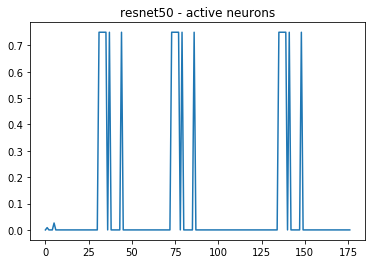

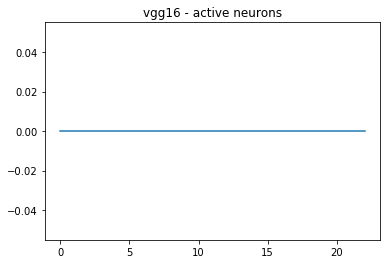

In [16]:
for model_name in model_names:
    plt.title(model_name + " - active neurons")
    plt.plot([(m.sum(-1) / m.shape[-1] > 0.999999).mean() for m in dead_neuron_mask[model_name]])
    plt.show()

In [17]:
nice_layer_names

{'vgg16': OrderedDict([(0, 'input'),
              (1, 'conv1_1'),
              (2, 'conv1_2'),
              (3, 'pool1'),
              (4, 'conv2_1'),
              (5, 'conv2_2'),
              (6, 'pool2'),
              (7, 'conv3_1'),
              (8, 'conv3_2'),
              (9, 'conv3_3'),
              (10, 'pool3'),
              (11, 'conv4_1'),
              (12, 'conv4_2'),
              (13, 'conv4_3'),
              (14, 'pool4'),
              (15, 'conv5_1'),
              (16, 'conv5_2'),
              (17, 'conv5_3'),
              (18, 'pool5'),
              (19, 'flatten'),
              (20, 'fc1'),
              (21, 'fc2'),
              (22, 'fc3')]),
 'resnet50': OrderedDict([(0, 'input'),
              (2, 'conv1'),
              (6, 'maxpool'),
              (7, 'conv2_1a'),
              (10, 'conv2_1b'),
              (13, 'conv2_1c'),
              (14, 'conv2_skip'),
              (18, 'block2_1'),
              (19, 'conv2_2a'),
              (22, 

In [18]:
histogram_layers = copy.deepcopy(replacement_layers)
histogram_layers['vgg16'].extend(['conv1_1', 'input'])
histogram_layers['resnet50'].extend(['conv2_1a', 'input'])

In [19]:

histogram_layers_idx = OrderedDict()
for model_name in model_names:
    histogram_layers_idx[model_name] = []
    for layer_name in histogram_layers[model_name]:
        idx = get_layer_idx_full(model_name, nice_layer_names, layer_name)
        histogram_layers_idx[model_name].append(idx) 
histogram_layers_idx

OrderedDict([('resnet50', [176, 154, 102, 80, 60, 28, 7, 0]),
             ('vgg16', [22, 20, 13, 9, 5, 1, 0])])

In [ ]:
# replacement_layer_indices = [22]
n_sampled_v = 5

cos_sim_histograms = {}
selected_percentiles = [0, 1, 5, 10, 20, 50, 100]
cos_sim_percentiles = {}

for label, innv_name, _, excludes, kwargs in tqdm.tqdm_notebook(analysers[:3]):
    if 'exclude_cos_sim' in excludes:
        continue
    for model_name in model_names[:1]:
        if 'exclude_' + model_name in excludes:
            continue
        keras.backend.clear_session()
        model_wo_softmax, innv_net, _ = load_model(model_name, load_weights=True)
        if innv_name == "pattern.attribution":
            kwargs['patterns'] = innv_net['patterns']

        for replacement_layer in replacement_layers[model_name]:
            replacement_layer_idx = get_layer_idx_full(model_name, nice_layer_names, replacement_layer)
            repl_analyser, repl_shape = get_replacement_analyser(
                model_wo_softmax, innv_name,  
                replacement_layer_idx=replacement_layer_idx,
                **kwargs)
            repl_analyser.create_analyzer_model()
            cos_per_img = OrderedDict()
            for img_idx, (img, _) in tqdm.tqdm_notebook(zip(selected_img_idxs, val_images), 
                desc="[{}.{}] {}".format(model_name, replacement_layer, label)):
                channels = repl_shape[-1]
                if label == "$\\alpha=100, \\beta=99$-LRP":
                    # a=100,b=99 sufferes numerical instabilities with std = 1
                    std = 1 / np.sqrt(channels)
                else:
                    std = 1

                relevance_v1 = std*np.random.normal(size=(1, ) + repl_shape[1:]) 
                hmap = repl_analyser.analyze([img, relevance_v1])
                intermediate_values = parse_reversed(repl_analyser._reversed_tensors)

                relevance_v2 = std * np.random.normal(size=(n_sampled_v,) + repl_shape[1:]) 
                img_tiled = np.tile(img, (n_sampled_v, 1, 1, 1))
                outs = repl_analyser.get_cosine(img_tiled, relevance_v2,  intermediate_values[::-1])
                outs = outs[1:][::-1]
                for layer_idx, (o, dead_neuron) in enumerate(zip(outs, dead_neuron_mask[model_name])):
                    active_neuron = ~dead_neuron
                    cos_per_img[model_name, layer_idx, img_idx] = np.stack([x[active_neuron[0]] for x in np.abs(o)])
            
            median_for_label = []
            percentile_for_label = OrderedDict([(p, []) for p in selected_percentiles])
            for layer_idx in range(n_layers[model_name] - 1):
                cos_per_layer = np.concatenate([cos_per_img[model_name, layer_idx, img_idx]  for img_idx in selected_img_idxs])
                cos_per_layer = cos_per_layer.flatten()
                perc_values = np.percentile(cos_per_layer,  selected_percentiles)
                for p, val in zip(selected_percentiles, perc_values):
                    percentile_for_label[p].append(val)
                    
                if layer_idx in histogram_layers_idx[model_name]:
                    idx = (label, model_name, replacement_layer_idx,  layer_idx)
                    
                    if len(cos_per_layer) > 50000:
                        ridx = np.random.choice(len(cos_per_layer), 50000, replace=False)
                        cos_per_layer_sel = cos_per_layer[ridx]
                    else:
                        cos_per_layer_sel = cos_per_layer
                        
                    cos_sim_histograms[idx] = np.histogram(cos_per_layer_sel, bins)


            for p, values in percentile_for_label.items():
                cos_sim_percentiles[label, model_name, replacement_layer_idx, p] = np.array(values)

/home/leonsixt/.conda/envs/py36/lib/python3.6/site-packages/innvestigate/applications/imagenet.py:134: UserWarning: There are no patterns for network 'resnet50'.
  warnings.warn("There are no patterns for network '%s'." % netname)


In [22]:
cos_per_layer.size

1000

In [ ]:
save_results = True
if save_results:
    os.makedirs('cache', exist_ok=True)
    with open('cache/cos_sim_with_resnet.pickle', 'wb') as f:
        pickle.dump((cos_sim_percentiles), f)

In [ ]:
load_results = True
if load_results:
    os.makedirs('cache', exist_ok=True)
    with open('cache/cos_sim_with_resnet.pickle', 'rb') as f:
        cos_sim_percentiles = pickle.load(f)

In [ ]:
def cosine_similarity(U, V):
    v_norm = V / np.linalg.norm(V, axis=0, keepdims=True)
    u_norm = U / np.linalg.norm(U, axis=0, keepdims=True)
    return v_norm.T @ u_norm

def get_sample_cos_sim_per_layer(output_shapes):
    values = []
    for layer_idx, shp in output_shapes.items():
        ch = shp[-1]
        n_samples = 1000
        u = np.random.normal(size=(ch, n_samples))
        v = np.random.normal(size=(ch, n_samples))
        cos = cosine_similarity(v, u)
        mask = np.tri(cos.shape[0])
        values.append(np.median(np.abs(cos[mask == 1])))
    return np.array(values)
        

In [ ]:
[n for (n, _, _, _, _) in analysers]

In [ ]:
next(iter(cos_sim_percentiles.items()))

In [ ]:
cos_sim_baseline = {}

for model_name in model_names:
    keras.backend.clear_session()
    model, _, _ = load_model(model_name)
    output_shapes = get_output_shapes(model)
    print(len(output_shapes))
    cos_sim_baseline[model_name] = get_sample_cos_sim_per_layer(output_shapes)

In [ ]:
model_names

In [ ]:
cos_sim_baseline['vgg16'].shape, cos_sim_baseline['resnet50'].shape

In [ ]:
legend = OrderedDict()

os.makedirs('figures', exist_ok=True)
for model_name in model_names[::-1]:
    for replacement_layer in replacement_layers[model_name]:
        repl_idx = get_layer_idx_full(model_name, nice_layer_names, replacement_layer)
        start_layer = n_layers[model_name] - repl_idx 
        
        layer_names = [name for idx, name in nice_layer_names[model_name].items()
                       if idx <= repl_idx][::-1]
        layer_idx = np.array([idx for idx, name in nice_layer_names[model_name].items()
                       if idx < repl_idx][::-1])
        
        print(layer_idx, repl_idx, start_layer)
        #layer_idx = layer_idxs
        
        plt.figure(figsize=(max(3, len(layer_idx) / 4), 3.5))
        
        for i, (label, _, _, _, _) in enumerate(analysers):
            idx = (label, model_name, repl_idx, 50)
            if idx not in cos_sim_percentiles:
                warnings.warn("not found: " + str(idx))
                continue
            cos_sim_per_label = cos_sim_percentiles[idx][n_layers[model_name] - layer_idx - 1][1:]
            plt.plot(0.5 + np.arange(len(cos_sim_per_label)), cos_sim_per_label, label=label, **mpl_styles[label])
            
            if label not in legend:
                legend[label] = mpl_styles[label]
            
        # Random Cos Similarity
        # Cos Similarity Base.
        label='Cos Similarity BL'
        style = {'color': (0.25, 0.25, 0.25)}
        plt.plot(0.5 + np.arange(len(layer_idx)), cos_sim_baseline[model_name][layer_idx], 
                 # label='Cos. Sim. Baseline', 
                 label=label,
                 **style)
        if label not in legend:
            legend[label] = style
        
        #plt.legend(bbox_to_anchor=(1, 1))
        plt.ylabel('cosine similarity')
        plt.xticks(np.arange(len(layer_names)), layer_names, rotation=90)
        plt.ylim(-0.05, 1.05)
        plt.grid('on', alpha=0.35) #, axis="y")
        plt.savefig("./figures/consine_similarity_{}_layer_{}.pdf".format(model_name, repl_idx),  
                    bbox_inches='tight', pad_inches=0)
        plt.show()
        plt.close()

In [ ]:
display(IFrame("./figures/cos_sim_legend.pdf", 800, 600))

In [ ]:
raise Exception('stop')